### Importing required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Loading the datasets

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('train df missing values:\n',train_df.isnull().sum()[train_df.isnull().sum() > 0])
print('test df missing values:\n',test_df.isnull().sum()[test_df.isnull().sum() > 0])

train df missing values:
 Age         177
Cabin       687
Embarked      2
dtype: int64
test df missing values:
 Age       86
Fare       1
Cabin    327
dtype: int64


### Data Cleaning

In [4]:
def clean_data(df):
    df = df.copy()

    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())

    df['Embarked'] = df['Embarked'].fillna('S')

    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    df['IsAlone'] = 0
    df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1
        
    df.drop(['Ticket', 'Cabin'], axis=1, inplace=True, errors='ignore')
    
    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df)

### Define Features & Target

In [5]:
X = train_df.drop(['Name','PassengerId','Survived'], axis=1)
y= train_df['Survived']

categorical_features = ['Sex', 'Embarked', 'Pclass'] 
numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone']

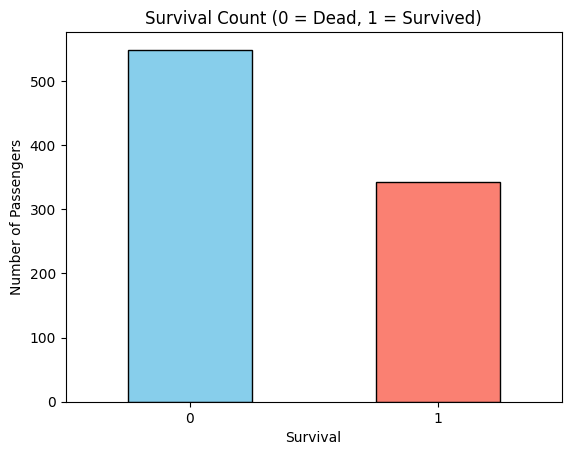

In [6]:
train_df['Survived'].value_counts().plot(
    kind='bar',
    color=['skyblue', 'salmon'],
    edgecolor='black'
)
plt.title("Survival Count (0 = Dead, 1 = Survived)")
plt.xlabel("Survival")
plt.ylabel("Number of Passengers")
plt.xticks(rotation=0)
plt.show()

### Preprocessor and Pipeline

In [7]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

### Hyperparameter Tuning

In [8]:
param_dist = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None]
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,         
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

### Train/Validation Split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)

Best Parameters: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 5}
Best Cross-Validation Accuracy: 0.8301093272924259


### Evaluation

In [11]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)
print("Classification Report:\n", classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85       105
           1       0.82      0.69      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179



### Submission

In [12]:
X_test = test_df.drop(['Name','PassengerId'], axis=1)
test_predictions = best_model.predict(X_test)

submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
